In [8]:
import torch
import numpy as np
import matplotlib.pylab as plt
from IPython.display import clear_output
import torch.nn as nn 

import antidistil
import pipeline
import consts
from importlib import reload
import plot
import json
reload(plot)
reload(antidistil)
plot.prepare_for_plots()

<Figure size 864x720 with 0 Axes>

In [2]:
train_dataloader, test_dataloader = pipeline.get_data()

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Zero:  distilling from full-training teacher

In [3]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
mask = torch.ones(10).to(consts.device)
for i in range(consts.num_repeats):
    clear_output()
    print(f"Model {i+1}\n-------------------------------"
                      "\n-------------------------------")

    torch.manual_seed(i)
    teacher = pipeline.make_teacher_model()
    teacher.load_state_dict(torch.load(pipeline.get_path()+f'/teacher_{i}.pt'))
    model = antidistil.simple_baseline_change_weights(teacher, 'zero')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=consts.full_student_learning_rate)
    
    for epoch in range(consts.full_student_training_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")

        pipeline.train_loop(model,  history, mask, train_dataloader, loss_fn, optimizer)
        pipeline.test_loop(model, history, mask, test_dataloader, loss_fn)
    pipeline.test_loop_fsgm(model, history, mask, test_dataloader, loss_fn, consts.fsgm_eps)
    pipeline.test_loop_noise(model, history, mask, test_dataloader, consts.noise_eps)
    torch.save(model.state_dict(), pipeline.get_path()+f'/zero_full_{i}.pt')

Model 1
-------------------------------
-------------------------------


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

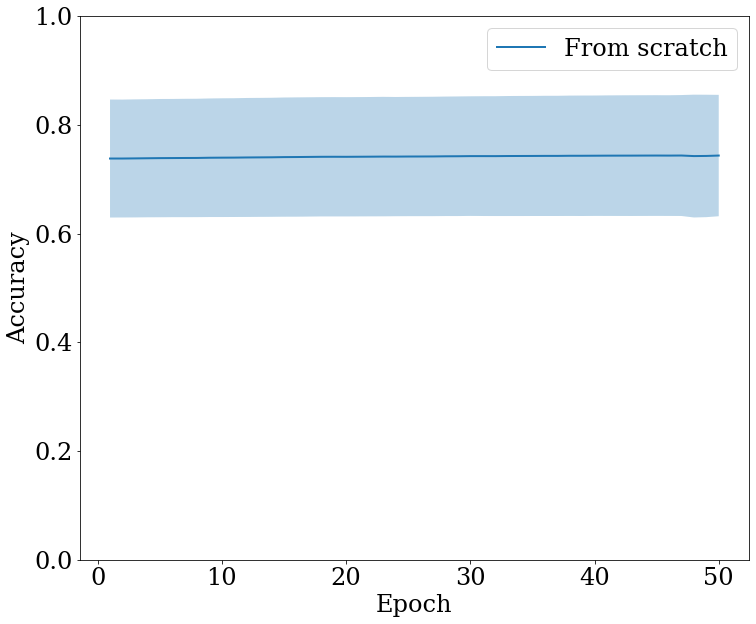

In [4]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], np.arange(1, consts.full_student_training_epochs+1),
                   ['From scratch'], 'val_acc', 
                    'Epoch', 'Accuracy')

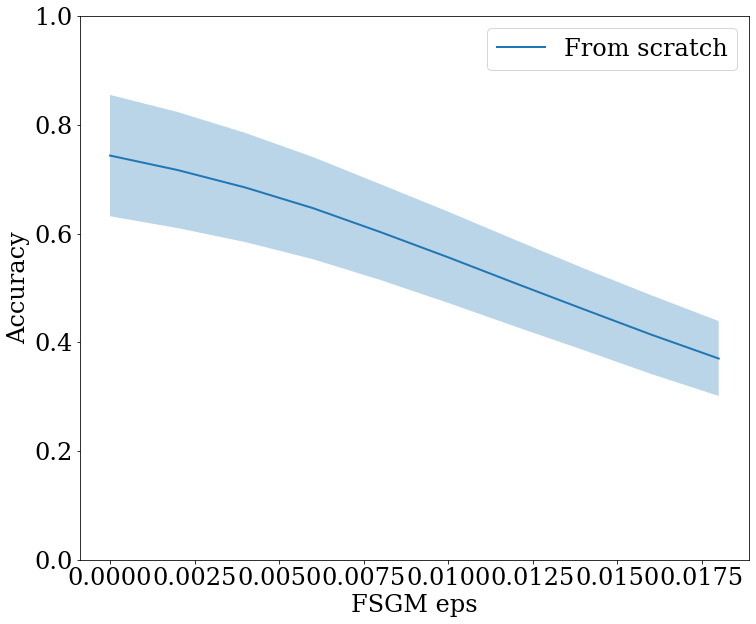

In [5]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'fsgm_noise_acc', 
                    'FSGM eps', 'Accuracy')

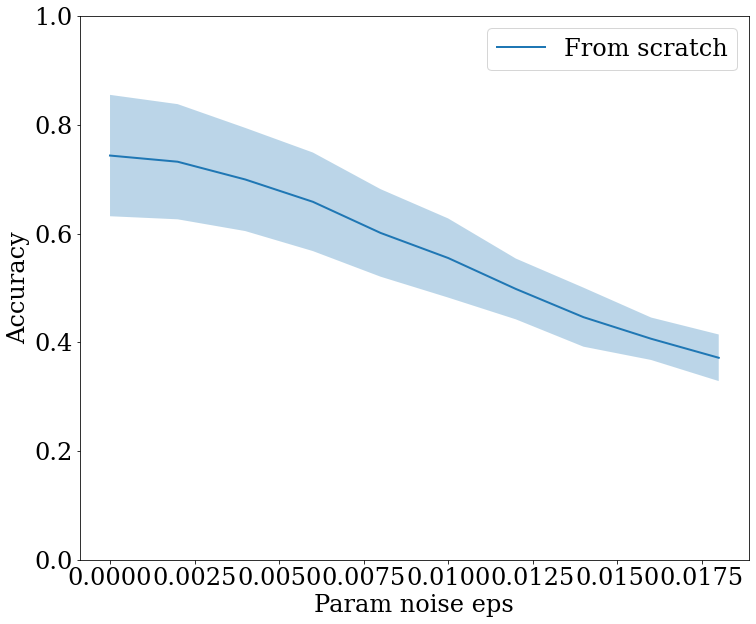

In [7]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'param_noise_acc', 
                    'Param noise eps', 'Accuracy')

In [8]:
with open(pipeline.get_path()+'/history_full_zero.json', 'w') as out:
    out.write(json.dumps(history))

# Zero: distilling from 5-classes trainer

In [18]:
mask = torch.ones(10).to(consts.device)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for i in range(consts.num_repeats):
    clear_output()
    print(f"Model {i+1}\n-------------------------------"
                      "\n-------------------------------")

    torch.manual_seed(i)

    teacher = pipeline.make_teacher_model()
    teacher.load_state_dict(torch.load(pipeline.get_path()+f'/teacher_5cl_{i}.pt'))
    model = antidistil.simple_baseline_change_weights(teacher, 'zero')
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=consts.student_5_learning_rate)
    
    for epoch in range(consts.student_5_training_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")

        pipeline.train_loop(model,  history, mask, train_dataloader, loss_fn, optimizer)
        
    pipeline.test_loop_fsgm(model, history, mask, test_dataloader, loss_fn, consts.fsgm_eps)
    pipeline.test_loop_noise(model, history, mask, test_dataloader, consts.noise_eps)
    torch.save(model.state_dict(), pipeline.get_path()+f'/zero_5_{i}.pt')

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Model 1
-------------------------------
-------------------------------
Epoch 1
-------------------------------


Batch #:   0%|          | 0/40 [00:00<?, ?it/s]           

FSGM Accuracy [0.7802, 0.7474, 0.7109, 0.6713, 0.634, 0.5984, 0.559, 0.5215, 0.4886, 0.4597]


Noise Accuracy [0.7802, 0.7778, 0.7606, 0.7405, 0.7252, 0.6899, 0.6496, 0.6434, 0.5847, 0.5817]


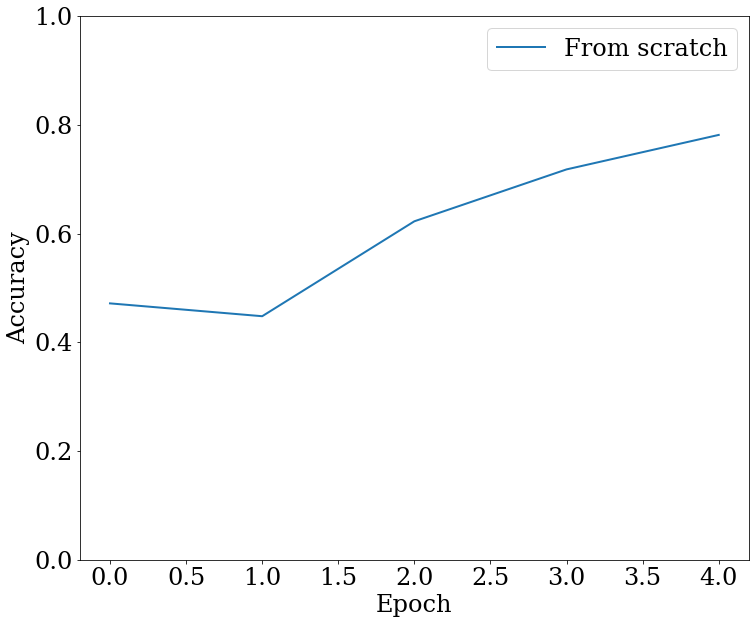

In [19]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], np.arange(5),
                   ['From scratch'], 'val_acc', 
                    'Epoch', 'Accuracy')

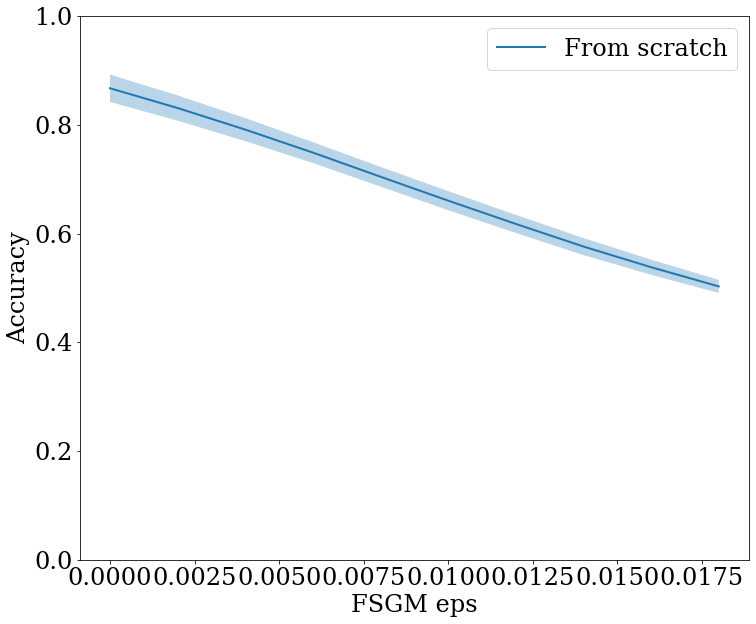

In [5]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'fsgm_noise_acc', 
                    'FSGM eps', 'Accuracy')

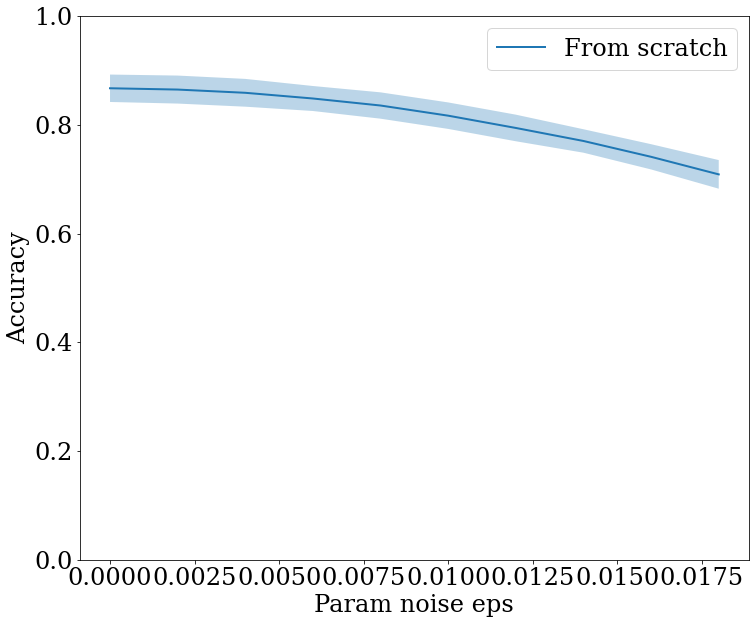

In [6]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'param_noise_acc', 
                    'Param noise eps', 'Accuracy')

In [7]:
with open(pipeline.get_path()+'/history_5_zero.json', 'w') as out:
    out.write(json.dumps(history))